In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from common_import import *

### Evaluate single experiment

In [3]:
checkpoint = 'MB_ft_h36m'
args, opts = get_opt_args_from_model_name(checkpoint, mode='best')
model_pos, chk_filename, checkpoint = load_model(opts, args)
print(args.gt_mode, args.mpjpe_mode)

subset = 'KOOKMIN-RTM-FOLD1'
args.subset_list = [subset]
train_loader, test_loader, _, _, datareader = load_dataset(args, use_new_datareader=True)

e1, e2, results_all, inputs_all, gts_all, total_result_dict = evaluate(args, model_pos, test_loader, datareader, checkpoint, only_one_batch=False)

configs/pose3d/MB_ft_h36m.yaml
True
MB_ft_h36m


Loading checkpoint checkpoint/pose3d/MB_ft_h36m/best_epoch.bin
joint3d_image joints_2.5d_image
Loading dataset...
KOOKMIN-RTM-FOLD1
[overwrite: False] ==> Loading KOOKMIN source_list...
[overwrite: False] ==> Loading KOOKMIN cam_param...
[overwrite: False] ==> Loading KOOKMIN cam_3d...
[overwrite: False] ==> Loading KOOKMIN img_3d...
[overwrite: False] ==> Loading KOOKMIN scale_factor...
[overwrite: False] ==> Loading KOOKMIN img_25d...
[overwrite: False] ==> Loading KOOKMIN img_2d...
INFO: Testing
No epoch information in the checkpoint


100%|██████████| 39/39 [00:15<00:00,  2.57it/s]


No eval_keypoint. Use part list
Part: whole
Protocol #1 Error (MPJPE): 493.30528404707445 mm
Protocol #2 Error (P-MPJPE): 205.89705186729887 mm
----------------------------------------


In [4]:
num_test_frames, action_clips, factor_clips, source_clips, frame_clips, gt_clips, actions = datareader.get_clip_info(args, len(results_all))

total_result_dict = {}
pelvis, r_hip, l_hip, torso, neck, l_shoulder, r_shoulder = 0, 1, 4, 7, 8, 11, 14
r_knee, r_ankle, l_knee, l_ankle = 2, 3, 5, 6
l_elbow, l_wrist, r_elbow, r_wrist = 12, 13, 15, 16
nose, head = 9, 10
action_names = datareader.get_action_list() # sorted(set(datareader.dt_dataset['test']['action']))
if 'H36M-SH' in args.subset_list:
    block_list = ['s_09_act_05_subact_02',
                's_09_act_10_subact_02',
                's_09_act_13_subact_01']
else: block_list = []

try:
    joint_list = args.eval_keypoint # Use only the specified keypoint number in config
    part = str(args.eval_keypoint)
    part_list = [part]
    args.eval_part = part
    total_result_dict[part] = {
        'e1_all': np.zeros(num_test_frames),
        'e2_all': np.zeros(num_test_frames),
        'oc': np.zeros(num_test_frames),
        'results': {},
        'results_procrustes': {}
    }

    # To classify the results by action
    for action in action_names:
        total_result_dict[part]['results'][action] = []
        total_result_dict[part]['results_procrustes'][action] = []
except:
    print('No eval_keypoint. Use part list')
    part_list = args.part_list
    for part in part_list:
        total_result_dict[part] = {
            'e1_all': np.zeros(num_test_frames),
            'e2_all': np.zeros(num_test_frames),
            'oc': np.zeros(num_test_frames),
            'results': {},
            'results_procrustes': {}
        }

        # To classify the results by action
        for action in action_names:
            total_result_dict[part]['results'][action] = []
            total_result_dict[part]['results_procrustes'][action] = []

No eval_keypoint. Use part list


In [21]:
for idx in range(len(results_all)):
    # check if the clip is in the block list
    if 'H36M-SH' in args.subset_list:
        source = source_clips[idx][0][:-6]
    else:
        source = source_clips[idx]
    if source in block_list:
        continue
    frame_list = frame_clips[idx] # range(idx*243, (idx+1)*243)
    action = action_clips[idx][0]
    factor = factor_clips[idx][:,None,None]
    gt = gt_clips[idx].copy()
    pred = results_all[idx].copy()
    if args.mpjpe_mode == 'joints_2.5d_image':
        pred *= factor # scaling image to world (mm) scale
        if args.gt_mode == 'joint3d_image':
            gt *= factor
    # Root-relative Errors
    if (args.model in ['DHDSTformer_total', 'DHDSTformer_total2', 'DHDSTformer_total3', 'DHDSTformer_total4', 'DHDSTformer_total5', 'DHDSTformer_total6', 'DHDSTformer_total7', 'DHDSTformer_total8', 'DHDSTformer_torso', 'DHDSTformer_torso_limb', 'DHDSTformer_right_upper_arm2']) or ('MB' in args.model): # only model that predict pelvis point
        pred = pred - pred[:,0:1,:] # (243, 17, 3)
        gt = gt - gt[:,0:1,:] # (243, 17, 3)

    if not args.mpjpe_after_part:
        # pred, gt: (243, 17, 3)
        err1_per_joint = mpjpe_for_each_joint(pred, gt) # (243, 17)
        try:
            err2_per_joint = p_mpjpe_for_each_joint(pred, gt) # (243, 17)
        except:
            #print('failed to calculate p_mpjpe')
            err2_per_joint = np.ones_like(err1_per_joint) * -1000

    for part in part_list:
        if part == 'whole': joint_list = [j for j in range(pred.shape[1])]
        elif part == 'whole_without_nose': joint_list = [j for j in range(pred.shape[1]) if j!=9]
        elif part == 'torso_small': joint_list = [pelvis, r_hip, l_hip, neck, l_shoulder, r_shoulder]
        elif part == 'torso_full': joint_list = [pelvis, r_hip, l_hip, torso, neck, nose, head, l_shoulder, r_shoulder]
        elif part == 'torso_full_to_small': joint_list = [0, 1, 2, 4, 7, 8]
        elif part == 'arms': joint_list = [l_elbow, l_wrist, r_elbow, r_wrist]
        elif part == 'right_arm': joint_list = [r_elbow, r_wrist]
        elif part == 'left_arm': joint_list = [l_elbow, l_wrist]
        elif part == 'right_leg': joint_list = [r_knee, r_ankle]
        elif part == 'left_leg': joint_list = [l_knee, l_ankle]
        elif part == 'legs': joint_list = [r_knee, r_ankle, l_knee, l_ankle]
        elif part == 'pelvis': joint_list = [pelvis]
        elif part == 'r_hip': joint_list = [r_hip]
        elif part == 'l_hip': joint_list = [l_hip]
        elif part == 'torso': joint_list = [torso]
        elif part == 'neck': joint_list = [neck]
        elif part == 'l_shoulder': joint_list = [l_shoulder]
        elif part == 'r_shoulder': joint_list = [r_shoulder]
        elif part == 'l_elbow': joint_list = [l_elbow]
        elif part == 'l_wrist': joint_list = [l_wrist]
        elif part == 'r_elbow': joint_list = [r_elbow]
        elif part == 'r_wrist': joint_list = [r_wrist]
        elif part == 'r_knee' : joint_list = [r_knee]
        elif part == 'r_ankle': joint_list = [r_ankle]
        elif part == 'l_knee' : joint_list = [l_knee]
        elif part == 'l_ankle': joint_list = [l_ankle]
        elif part == 'nose'   : joint_list = [nose]
        elif part == 'head'   : joint_list = [head]

        if args.mpjpe_after_part:
            err1_per_joint = mpjpe_for_each_joint(pred[:, joint_list], gt[:, joint_list]) # (243, 17)
            err2_per_joint = p_mpjpe_for_each_joint(pred[:, joint_list], gt[:, joint_list]) # (243, 17)
            err1 = np.mean(err1_per_joint, axis=1)
            err2 = np.mean(err2_per_joint, axis=1)
        else:
            err1 = np.mean(err1_per_joint[:, joint_list], axis=1) # mpjpe(pred, gt) # (243, )
            err2 = np.mean(err2_per_joint[:, joint_list], axis=1) # p_mpjpe(pred, gt)
        if 'NO_FACTOR' in args.subset_list[0]:
            err1 *= 1000
            err2 *= 1000
        print(err1.mean(), err2.mean())
        total_result_dict[part]['e1_all'][frame_list] += err1 # (243, ) # 각 프레임 별 에러를 더해줌
        total_result_dict[part]['e2_all'][frame_list] += err2 # (243, ) # 각 프레임 별 에러를 더해줌
        total_result_dict[part]['oc'][frame_list] += 1

# Error per action
for idx in range(num_test_frames):
    for part in part_list:
        if total_result_dict[part]['e1_all'][idx] > 0:
            err1 = total_result_dict[part]['e1_all'][idx] / total_result_dict[part]['oc'][idx]
            err2 = total_result_dict[part]['e2_all'][idx] / total_result_dict[part]['oc'][idx]
            action = actions[idx]
            total_result_dict[part]['results'][action].append(err1)
            total_result_dict[part]['results_procrustes'][action].append(err2)

128.2249151640006 84.58590711911064
369.40981621169703 236.28995314934113
312.3752664779176 202.81824014397066
109.34705593833742 93.02203769733123
258.86587759480216 214.72803827494607
296.9547499396008 228.56539408600608
129.82621961958407 100.01638986853193
159.46683343050339 126.958971878489
146.1276802307163 120.96196949167023
149.66868705481124 121.965448061897
148.9935733090869 119.1767430997193
120.44559746216952 99.67043144202667
270.463424652209 269.3485464771667
285.4341104148244 288.76767718670504
100.43190602500125 87.87009125744584
205.98995897960452 193.59421516436802
340.36968125205885 328.25744006860197
273.7107197856389 260.6554445951706
86.85138801374852 66.0117456861688
117.19347514765916 86.8129028380893
466.8824073008199 389.7424026541667
504.47292485719765 419.01586563620333
440.103238971508 359.11563471152914
547.2502813196512 453.13580707398495
178.13086360199992 145.02433728789134
92.36783279641513 73.39946838340272
128.94316201076066 85.41719251210417
327.262

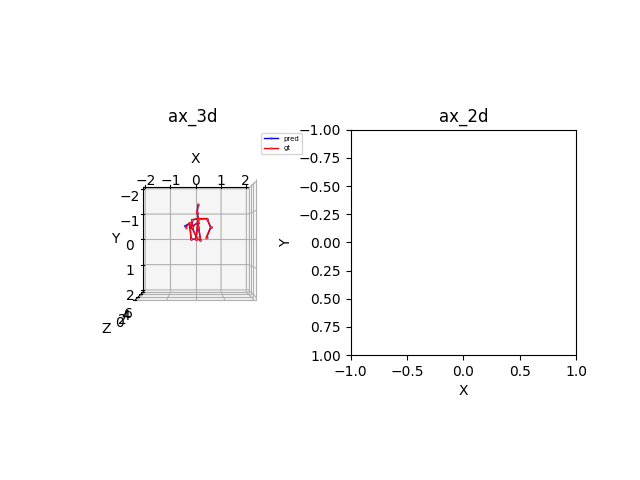

In [23]:
%matplotlib widget
# check original train data
frame_num = 100
configs = {
    'ax_3d': {'type': '3d', 'loc': 121, 'mode': 'cam', 'zlim': [0, 6]},
    'ax_2d': {'type': '2d', 'loc': 122, 'normalize': True},
}
fig, axs = generate_axes(0, configs, fig_title='')
plot_pose_setting = [
    ('ax_3d', pred/1000,                        {'color': 'b', 'label': 'pred'}),
    ('ax_3d', gt/1000,                        {'color': 'r', 'label': 'gt'}),
    #('ax_2d', inputs_all[idx], {'color': 'b', 'label': 'input'}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

In [47]:
checkpoint_name = 'MB_train_h36m_gt_cam_no_factor_tr_s1_ts_s5678'
save_folder = f'/home/hrai/codes/MotionBERT/saved_results/{checkpoint_name}'
if not os.path.exists(save_folder): os.makedirs(save_folder)

# load model
args, opts = get_opt_args_from_model_name(checkpoint_name, verbose=False)
model_pos, chk_filename, checkpoint = load_model(opts, args)

subset = '3DHP-GT-CAM_NO_FACTOR-TEST_TS1_6_UNIV'
if 'PCL' in subset: args.fix_orientation_pred = True # load dataset
args.subset_list = [subset]
train_loader, test_loader, _, _, datareader = load_dataset(args, use_new_datareader=True)
e1, e2, results_all, inputs_all, gts_all, total_result_dict = evaluate(args, model_pos, test_loader, datareader, checkpoint, only_one_batch=False)

# save results
save_path = os.path.join(save_folder, f'{subset}.pkl')
results_dict = {'results_all': results_all, 'gts_all': gts_all, 'inputs_all': inputs_all, 'total_result_dict': total_result_dict, 'e1': e1, 'e2': e2}
savepkl(results_dict, save_path)

MB_train_h36m_gt_cam_no_factor_tr_s1_ts_s5678
Loading checkpoint checkpoint/pose3d/MB_train_h36m_gt_cam_no_factor_tr_s1_ts_s5678/best_epoch.bin
Loading dataset...
3DHP-GT-CAM_NO_FACTOR-TEST_TS1_6_UNIV
[overwrite: False] ==> Loading 3DHP source_list...
[overwrite: False] ==> Loading 3DHP cam_param...
[overwrite: False] ==> Loading 3DHP cam_3d...
[overwrite: False] ==> Loading 3DHP img_2d...
INFO: Testing
No epoch information in the checkpoint


100%|██████████| 6/6 [00:03<00:00,  1.98it/s]


No eval_keypoint. Use part list
Part: whole
Protocol #1 Error (MPJPE): 93.91986757337212 mm
Protocol #2 Error (P-MPJPE): 66.60678016191338 mm
----------------------------------------


In [44]:
# remove result from result_dict
result_dict = readpkl('result_dict.pkl')
del result_dict[checkpoint_name][subset]
savepkl(result_dict, 'result_dict.pkl')

KeyError: '3DHP-GT-CAM_NO_FACTOR-INPUT_FROM_CANONICAL_REVOLUTE-TEST_TS1_6'

### Evaluate and save all experiments

In [2]:
result_list = os.listdir('saved_results')
checkpoint_list = os.listdir('checkpoint/pose3d')
whitelist_checkpoint = []
for item in os.listdir('configs/pose3d'):
    checkpoint = item.split('.yaml')[0]
    if 'cam_no_factor' not in checkpoint: continue
    if checkpoint in blacklist_checkpoint: continue
    if checkpoint not in checkpoint_list:
        print(f'[Need to be trained] {checkpoint}')
        continue
    if checkpoint not in experiment_list:
        whitelist_checkpoint.append(checkpoint)
        # create empty file
        with open(f'experiments/{checkpoint}.txt', 'w') as f:
            pass
    else:
        subset_list = []
        with open(f'experiments/{checkpoint}.txt', 'r') as f:
            lines = f.readlines()
            for line in lines:
                subset = line.split('\n')[0]
                subset_list.append(subset)
        if len(subset_list) == 0:
            print(f'[No subset fou  d] {checkpoint}')
            whitelist_checkpoint.append(checkpoint)
        for subset in subset_list:
            if not os.path.exists(f'saved_results/{checkpoint}/{subset}.pkl'):
                print(f'[Result not found] {checkpoint} - {subset}')
                if checkpoint not in whitelist_checkpoint:
                    whitelist_checkpoint.append(checkpoint)

print('\nCheckpoints to evaluate:')
whitelist_checkpoint

[No subset fou  d] MB_train_h36m_gt_cam_no_factor_no_rootrel
[Need to be trained] MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_same_z_input_centering_steprot_3+original_tr_s1_ts_s5678
[Need to be trained] MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_same_z_steprot_1_tr_s1_ts_s5678
[Need to be trained] MB_train_h36m_gt_cam_no_factor_sinu_roll_m15_p273_tr_s1_ts_s5678
[No subset fou  d] MB_train_h36m_gt_cam_no_factor_fix_orientation_gt_input_centering
[Result not found] MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering - H36M-GT-CAM_NO_FACTOR-INPUT_FROM_CANONICAL_PCL
[Result not found] MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering - H36M-GT-CAM_NO_FACTOR-INPUT_FROM_3D_CANONICAL_REVOLUTE

Checkpoints to evaluate:


['MB_train_h36m_gt_cam_no_factor_no_rootrel',
 'MB_train_h36m_gt_cam_no_factor_fix_orientation_gt_input_centering',
 'MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering']

In [16]:
whitelist_checkpoint = [
    # 'MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering',
    # 'MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering_tr_s1_ts_s5678',
    # 'MB_train_h36m_gt_cam_no_factor_input_from_canonical_pcl_input_centering_fix_orientation_pred_tr_s1_ts_s5678',
    # 'MB_train_h36m_gt_cam_no_factor_input_from_canonical_pcl_input_centering_fix_orientation_pred'
    'MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering',
    'MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering_tr_s1_ts_s5678'
]

In [17]:
motionbert_root = f'/home/{user}/codes/MotionBERT'
for checkpoint in whitelist_checkpoint:
    experiment_path = f'{motionbert_root}/experiments/{checkpoint}.txt'
    config_path = f'{motionbert_root}/configs/pose3d/{checkpoint}.yaml'
    print(f'{checkpoint}')
    if os.path.exists(experiment_path): print(f'Experiment path: {experiment_path}')
    else: print(f'[No experiment path] {experiment_path}')
    if os.path.exists(config_path): print(f'Config path: {config_path}')
    else: print(f'[No config path] {config_path}')

MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering
Experiment path: /home/hrai/codes/MotionBERT/experiments/MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering.txt
Config path: /home/hrai/codes/MotionBERT/configs/pose3d/MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering.yaml
MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering_tr_s1_ts_s5678
Experiment path: /home/hrai/codes/MotionBERT/experiments/MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering_tr_s1_ts_s5678.txt
Config path: /home/hrai/codes/MotionBERT/configs/pose3d/MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering_tr_s1_ts_s5678.yaml


In [ ]:
experiment_root = f'/home/{user}/codes/MotionBERT/experiments'
for item in glob(experiment_root+'/*.txt'):
    checkpoint = os.path.basename(item).split('.txt')[0]
    if checkpoint in blacklist_checkpoint: continue
    if len(whitelist_checkpoint) > 0 and checkpoint not in whitelist_checkpoint: continue
    if 'cam_no_factor' not in checkpoint: continue
    save_folder = f'/home/hrai/codes/MotionBERT/saved_results/{checkpoint}'
    if not os.path.exists(save_folder): os.makedirs(save_folder)

    # load model
    args, opts = get_opt_args_from_model_name(checkpoint, verbose=False)
    model_pos, chk_filename, checkpoint = load_model(opts, args)

    subset_list = []
    with open(item, 'r') as f:
        lines = f.readlines()
        for line in lines:
            subset = line.strip()
            subset_list.append(subset)

    for subset in subset_list:
        if 'PCL' in subset: args.fix_orientation_pred = True
        save_path = os.path.join(save_folder, f'{subset}.pkl')
        if os.path.exists(save_path):
            print(f'{save_path} exists')
            continue
        try:
            # load dataset
            args.subset_list = [subset]
            train_loader, test_loader, _, _, datareader = load_dataset(args, use_new_datareader=True)
            # evaluation
            e1, e2, results_all, inputs_all, gts_all, total_result_dict = evaluate(args, model_pos, test_loader, datareader, checkpoint, only_one_batch=False)
            # save results
            results_dict = {'results_all': results_all, 'gts_all': gts_all, 'inputs_all': inputs_all, 'total_result_dict': total_result_dict, 'e1': e1, 'e2': e2}
            savepkl(results_dict, save_path)
        except Exception as e:
            print(f'Error: {e}')


MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering_tr_s1_ts_s5678
Loading checkpoint checkpoint/pose3d/MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering_tr_s1_ts_s5678/best_epoch.bin
/home/hrai/codes/MotionBERT/saved_results/MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering_tr_s1_ts_s5678/H36M-GT-CAM_NO_FACTOR-INPUT_FROM_CANONICAL_PCL-TR_S1_TS_S5678.pkl exists
/home/hrai/codes/MotionBERT/saved_results/MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering_tr_s1_ts_s5678/H36M-GT-CAM_NO_FACTOR-INPUT_FROM_CANONICAL_PCL.pkl exists
/home/hrai/codes/MotionBERT/saved_results/MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering_tr_s1_ts_s5678/3DHP-GT-CAM_NO_FACTOR-INPUT_FROM_CANONICAL_PCL-TEST_TS1_6.pkl exists
/home/hrai/codes/MotionBERT/saved_results/MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering_tr_s1_ts_s5678/3DHP-GT-CA

100%|██████████| 6/6 [00:03<00:00,  1.96it/s]
/home/hrai/miniconda3/envs/motionbert/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/hrai/miniconda3/envs/motionbert/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No eval_keypoint. Use part list
Part: whole
Protocol #1 Error (MPJPE): nan mm
Protocol #2 Error (P-MPJPE): nan mm
----------------------------------------
Loading dataset...
3DHP-GT-CAM_NO_FACTOR-INPUT_FROM_3D_CANONICAL_REVOLUTE-TEST_ALL_TRAIN
[overwrite: False] ==> Loading 3DHP source_list...
[overwrite: False] ==> Loading 3DHP cam_param...
[overwrite: False] ==> Loading 3DHP cam_3d...
[overwrite: False] ==> Loading 3DHP cam_3d_canonical_revolute...
[overwrite: False] ==> Loading 3DHP img_2d_canonical_revolute...
INFO: Testing
No epoch information in the checkpoint


 10%|▉         | 24/245 [00:09<01:23,  2.65it/s]


In [4]:
with torch.no_grad():
    for batch_input, batch_gt in tqdm(test_loader): # batch_input: normalized joint_2d, batch_gt: normalized joint3d_image
        batch_size = len(batch_input)
        # preprocessing
        batch_gt_original = batch_gt.clone().detach().cuda()
        batch_input, batch_gt, batch_gt_torso, batch_gt_limb_pos = preprocess_eval(args, batch_input, batch_gt)
        # inference
        predicted_3d_pos = batch_inference_eval(args, model_pos, batch_input, batch_gt, batch_gt_torso, batch_gt_limb_pos)
        break

  0%|          | 0/6 [00:00<?, ?it/s]


In [17]:
np.linalg.norm(pose3d_gt - pose3d_pred)

8.880812

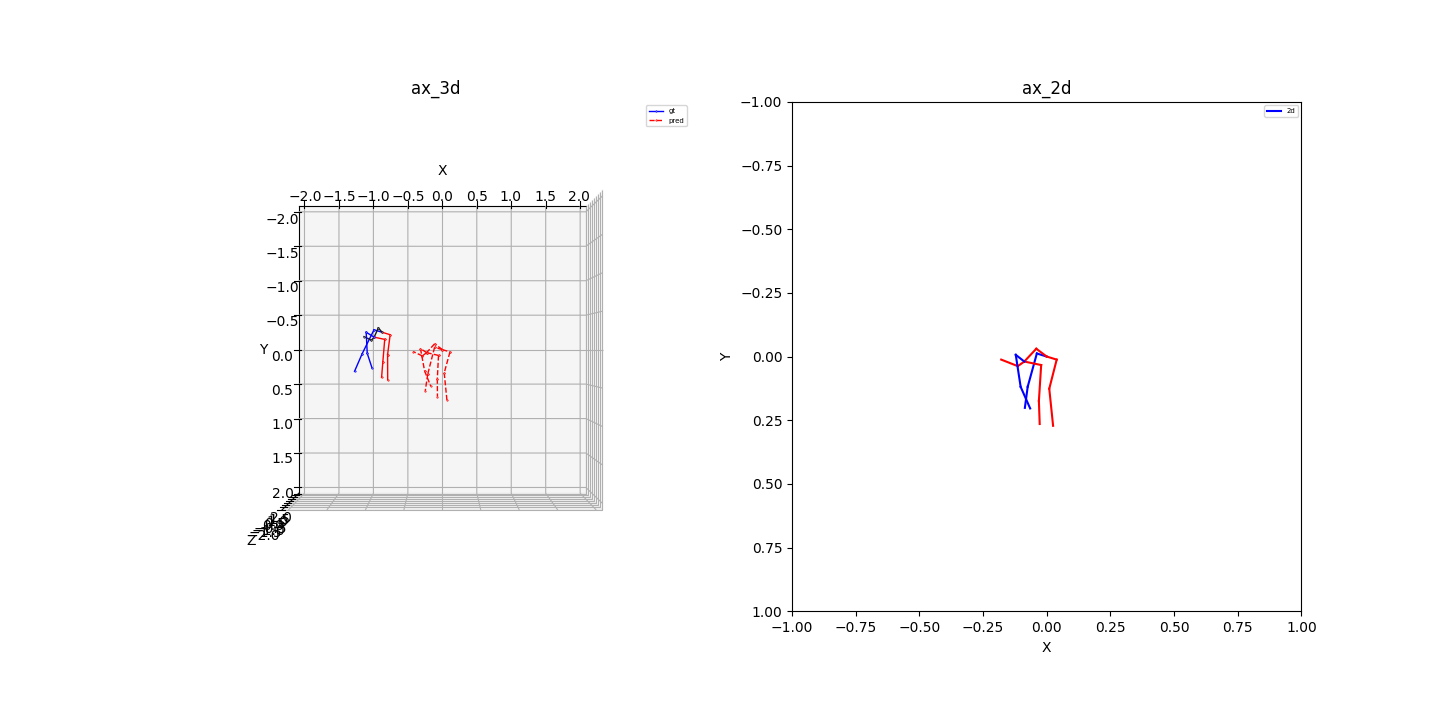

In [18]:
batch_num, frame_num = 10, 10
pose2d_norm = batch_input[batch_num].cpu().numpy()
#pose2d = denormalize_input(pose2d_norm, 1000, 1000)
pose3d_original_gt = batch_gt_original[batch_num].cpu().numpy()
# pose3d_original_hat = pose3d_original.copy() - pose3d_original[0:1]
pose3d_gt = batch_gt[batch_num].cpu().numpy()
pose3d_pred = predicted_3d_pos[batch_num].cpu().numpy()

configs = {
    'ax_3d': {'type': '3d', 'loc': 121, 'mode': 'cam'},
    'ax_2d': {'type': '2d', 'loc': 122, 'normalize': True},
}
fig, axs = generate_axes(2, configs, fig_title='')
plot_pose_setting = [
    ('ax_3d', pose3d_original_gt,           {'color': '', 'label': 'gt'}),
    ('ax_3d', pose3d_pred,         {'color': 'r', 'label': 'pred', 'linestyle': '--'}),
    ('ax_2d', pose2d_norm,         {'color': '', 'label': '2d'}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

### Cherrypick e1, e1 -> result_dict.pkl

In [45]:
blacklist_checkpoint = ['MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_same_z_s15678_tr_54138969_ts_others']

if os.path.exists('result_dict.pkl'):
    print('Loading result_dict.pkl')
    result_dict = readpkl('result_dict.pkl')
else:
    result_dict = {}
result_root = '/home/hrai/codes/MotionBERT/saved_results'
checkpoint_list = os.listdir(result_root)
for checkpoint in tqdm(checkpoint_list):
    if checkpoint in blacklist_checkpoint: continue # skip
    if checkpoint not in result_dict.keys(): result_dict[checkpoint] = {} # create new key if not exists
    checkpoint_root = os.path.join(result_root, checkpoint)
    subset_list = glob(checkpoint_root+'/*.pkl')
    for item in subset_list:
        subset = os.path.basename(item).split('.pkl')[0]
        if subset in result_dict[checkpoint].keys(): 
            #print(f'{subset} exists')
            continue
        result = readpkl(item)
        result_dict[checkpoint][subset] = {'e1': result['e1'], 'e2': result['e2']}
savepkl(result_dict, 'result_dict.pkl')

Loading result_dict.pkl


100%|██████████| 80/80 [00:00<00:00, 887.97it/s]


In [12]:
import prettytable

# PrettyTable 객체 생성 및 필드 설정
pt = prettytable.PrettyTable()
pt.field_names = ['Checkpoint', 'Subset', 'E1', 'E2']

# 데이터를 리스트에 수집
data = []
for key in result_dict.keys():
    for subset in result_dict[key].keys():
        if 'UNIV' not in subset: 
            continue
        e1 = float(result_dict[key][subset]['e1'])
        e2 = float(result_dict[key][subset]['e2'])
        data.append([key, subset, e1, e2])

# 데이터를 Subset 1순위, E1 2순위로 정렬
data_sorted = sorted(data, key=lambda x: (x[1], x[2]))

# 정렬된 데이터를 테이블에 추가
for row in data_sorted:
    pt.add_row([row[0], row[1], f'{row[2]:.2f}', f'{row[3]:.2f}'])

# 테이블 출력
print(pt)


+-------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------+--------+-------+
|                                                                       Checkpoint                                                                      |                                  Subset                                  |   E1   |   E2  |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------+--------+-------+
|                                    MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_revolute_input_centering                                    |  3DHP-GT-CAM_NO_FACTOR-INPUT_FROM_3D_CANONICAL_REVOLUTE-TEST_TS1_6_UNIV  | 61.17  | 48.02 |
|               